## Load libraries

In [1]:
%matplotlib notebook
import numpy as np
import operator as op
import matplotlib as mpl
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc

import cupy as qp
# stub to use when cupy cannot be imported
# class qp():
#    @staticmethod
#    def asnumpy(x):
#        return x

# select device to use
xp = np

## Define Display functions

In [2]:
# display functions

def disp3d(fig, aa, lines=(35,35)): # 3d wirefram plot
    # transfer input to device
    aa = qp.asnumpy(aa)
    
    #'wires' of the wireframe plot
    x = np.linspace(0, aa[0].shape[0]-1, lines[0], dtype=int)
    y = np.linspace(0, aa[0].shape[1]-1, lines[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    
    #display it
    ax = fig.add_subplot(111, projection='3d')
    A = aa #[xx,yy]
    ax.plot_wireframe(xx, yy, A)    
    return ax


def genframes(a, frames=np.arange(120, dtype=int)):
    f = []#np.empty((frames.shape[0],))
#     assert frames.dtype==int, "frames must be a numpy array of integers"
    frames = np.asarray(frames, dtype=int)
    mm = np.max([-np.min(a), np.max(a)])/2
    for fnum in range(frames.shape[0]-1):
        d = np.asarray(a[frames[fnum]], dtype=np.float32) # data
        im = plt.imshow(d, animated=True, vmin=-mm, vmax=mm,cmap='seismic')
        f.append([im])
    return f

# def motioncon(fig, f): # animated height plot, takes in list of 2d height arrays
    #prepare figure/display
    
#     z = qp.asnumpy(f[0])
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     mm = np.max([-np.min(f), np.max(f)])/2
#     im = ax.imshow(z, vmin=-mm, vmax=mm,cmap='seismic')
#     cb = fig.colorbar(im)
#     tx = ax.set_title(title)
#     plt.xticks(np.linspace(0, z.shape[0], xlabels.shape[0]), xlabels)
#     plt.yticks(np.linspace(0, z.shape[1], ylabels.shape[0]), ylabels)
    
#     def animate(i): # returns i'th element (height array) in f
#         im.set_data(qp.asnumpy(f[i]))
#         plt.contour(h, levels=1, cmap='gray')
    
    #display it
#     anim = animation.ArtistAnimation(fig, f)
#     return anim

def vect(u, v, arws=(10, 10), arwsz=100): # vector /motion plot
    #interpert inputs
    u = qp.asnumpy(u)
    v = qp.asnumpy(v)
#     if (xlim=='default'): xlim = (0, u.shape[0])
#     if (ylim=='default'): ylim = (0, v.shape[1])
    arws = (int(arws[0]), int(arws[1]))
    
    # set up
    x = np.linspace(0, u.shape[0]-1, arws[0], dtype=int)
    y = np.linspace(0, v.shape[1]-1, arws[1], dtype=int)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    uu = u[x,y]
    vv = v[x,y]
    m = np.hypot(uu, vv)
    
    #displat it
    q = plt.quiver(xx, yy, uu, vv, m, scale = 1/arwsz)
#     return ax
#     ax.set_xlim(xlim)
#     ax.set_ylim(ylim)
#     plt.title(title)
#     plt.show()

## Differentials of 2D arrays
Values live on a 2D grid.  
> Inputs:
> > a:  2D Matrix of values [N,M].  The matrix is ordered [i,j] so that increasing i, is increasing x, and increasing j is increasing y.<br>
        dx or dy: the width of the grid unit cell in some units.
    
> Evaluates:
> > derivative by subtracting adjacent values and dividing by the grid width.
As written dx and dy can either be constant scalar or an array that is (N-1,M) or (N,M-1) in size depending on if the derivative is on dx or dy, respectively. This allow for non-constant grid cell spacing as appropriate for equi-lattitude and longitude spaced grids.

> Outputs: 
> > the Returned array size is shorter by one along the direction (x or y) of the grid.  Effectively then the values represent the rate of change at points inbetween the neighboring points.  For the C-grid represnentaion the u,v speeds are values in between the n,h heights.


In [ ]:
# useful math functions
def d_dx(a, dx):
    ddx = ( a[:-1] - a[1:] )*(-1/dx) 
    return ddx
def d_dy(a, dy):
    ddy = ( a[:,:-1] - a[:,1:] )*(-1/dy)
    return ddy
def div(u, v, dx, dy):
    div = d_dx(u, dx) + d_dy(v, dy)
    return div

# for generating simple environments or initial conditions
# def hydrodynamic

In [ ]:
def planegauss(shape, win=((-2, 2), (-2, 2))):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0][0], win[0][1], shape[0] )
    npy = np.linspace( win[1][0],win[1][1], shape[1] )
    npxx, npyy = np.meshgrid(npx, npy, indexing='ij')
    h = np.exp( -np.e * ( npxx*npxx + npyy*npyy ) )
    return (h)
def lingauss(shape, w = 1/2, ax = 0, win = (-2, 2)):
   # h=np.empty(shape, dtype=np.float32)
    npx = np.linspace( win[0], win[1], shape[0] )
    npy = np.linspace( win[0], win[1], shape[1] )
    npxx, npyy = np.meshgrid(npy, npx)
    xy = (npyy, npxx)[ax]
    h = np.exp( -np.e * ( xy*xy ) / (w*w) )
    return (h)

## Physical constant and simulation parameters

In [ ]:
class params():
    minCoastDepth=20

    # physics constants
class p():
    g = np.float32(9.81) # gravity

## Class of objects to hold current state of an ocean grid 
heights, velocites, lattidutes.
### Coriolis Force
$$
\begin{align}
U & = R \cos(\phi) O \\
u_i & = U+u_r \\
u_r & = u_i-U \\
\frac{\partial U}{\partial phi} & = -R \sin(\phi) O \\
        phi & = y/R \\
       \frac{\partial \phi}{\partial t}  & = v/R \\ 
        \frac{\partial U}{\partial t} & = v (-\sin(phi) O) \\
        \frac{\partial u_r}{\partial phi}  = \frac{\partial u_i}{\partial t} - \frac{\partial U}{\partial t} & = v O \sin(phi) \\
       \frac{\partial u_r}{\partial t} & = v O \sin(phi)      
\end{align}
$$

        


In [4]:
class State(): # state args dx, dy, lat, lon, h, n, u, v
    def __init__(self, dx, dy, lat, lon, h, n, u, v):
        
        self.dx = dx
        self.dy = dy
        self.lat = lat 
        self.lon = lon
#         self.lat, self.lon = np.meshgrid(self.lat, self.lon) # lattitude/longitude chunk simulation area stretches over
        self.h = h
        
        self.maxws = np.sqrt(np.max(self.h)*p.g) # maximum wave speed
        
        self.n = np.asarray(n, dtype=np.float32) # surface height (eta)
        self.u = np.asarray(u, dtype=np.float32) # x vel array
        self.v = np.asarray(v, dtype=np.float32) # y vel array
        
        #make sure h is the same shap as n (eta)
        assert (np.isscalar(h) or self.h.shape == self.n.shape), "H and N must have the same shape, or H must be a scalar" # 'or' is short circuit
        
        self.calcDt()
        
        self.coriolis = (np.pi*np.sin(self.lat))/(43200*self.dt) # rotation speed of the earth dtheta/dt
        """ derivation of coriolis force
        U = R*cos(phi)*O
        ui = U+ur
        ur = ui-U
        dU/dphi = -R*sin(phi)*O
        phi = y/R
        dphi/dt = v/R
        dU/dt = v*(-sin(phi)*O)
        dur/dt = dui/dt - dU/dt = v*O*sin(phi)
        dur/dt = v*O*sin(phi)"""
        self.movetodevice()
    def movetodevice(self):
        '''Does nothing if device is CPU, moves arrays on GPU if GPU'''
        self.lat = xp.asarray(self.lat)
        self.lon = xp.asarray(self.lon)
        self.h = xp.asarray(self.h)
        self.n = xp.asarray(self.n)
        self.u = xp.asarray(self.u)
        self.v = xp.asarray(self.v)
        self.coriolis = xp.asarray(self.coriolis)
    def calcDt(self, fudge = 5): #calculate optimal value of dt for the height and dx values
        '''Hyperbolic differential wave equations go unstable if the wave can move more than 
        one grid element in one time step.  This function sets the time step to be short enough
        for the smallest grid element spacing in use. A fudge factor (default 5) is optional for an 
        extra margin of numerical stability at the cost of slower processing: setting this below one is not reccomended'''
        dx = np.min(self.dx)
        dy = np.min(self.dy)
        self.dt = np.min((dx, dy))/(fudge*self.maxws)

props = op.itemgetter('dx', 'dy', 'lat', 'lon', 'h', 'n', 'u', 'v') # for grrabbing the elements of a state

In [5]:
def dndt(h, n, u, v, dx, dy) : # change in n per timestep, defined in diff. equations
    hx = xp.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype) # to be x (u) momentum array
    hy = xp.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    hx[1:-1] = ((h+n)[1:] + (h+n)[:-1])/2 # average to same shape as u
    hx[0] = hx[-1] = 0.0 # reflective boundaries/borders
    hy[:,1:-1] = ((h+n)[:,1:] + (h+n)[:,:-1])/2
    hy[:,0] = hy[:,-1] = 0.0
#     print(hx.shape, u.shape)
    hx *= u # height/mass->momentum of water column.
    hy *= v
    dndt = (div(hx, hy, -dx, -dy))
    return ( dndt )

def dudt(n, dx) : # change in x vel. (u) per timestep
    dudt = xp.empty((n.shape[0]+1, n.shape[1]), dtype=n.dtype) # x accel array
    dudt[1:-1] = d_dx(n, -dx/p.g)
#     dudt += coriolis*v # coriolis force, from earth's rotation
    dudt[0] = dudt[-1] = 0 # reflective boundaries
    return ( dudt )

def dvdt(n, dy) :
    dvdt = xp.empty((n.shape[0], n.shape[1]+1), dtype=n.dtype)
    dvdt[:,1:-1] = d_dy(n, -dy/p.g)
    dvdt[:,0] = dvdt[:,-1] = 0
    return ( dvdt )

def land(h, u ,v): # how to handle land/above water area
    #boundaries / land
     ####  removed magic number.  was 3, now 20 meters
    coastx = xp.less(h, params.minCoastDepth) # start a little farther than the coast so H+n is never less than zero
    (u[1:])[coastx] = (u[:-1])[coastx] = 0 # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = (v[:,:-1])[coastx] = 0
    return (u, v)

def forward(h, n, u, v, dt, dx, dy, doland, beta=0): # forward euler and forward/backward timestep
    # beta = 0 => forward, beta = 1 => forward-backward
    n1 = n + ( dndt(h, n, u, v, dx, dy) )*dt
    u1 = u + ( beta*dudt(n1, dx) +  (1-beta)*dudt(n, dx) )*dt
    v1 = v + ( beta*dvdt(n1, dy) +  (1-beta)*dvdt(n, dy) )*dt
    u1, v1 = doland(h, u1, v1) # handle any land in the simulation
    return n1, u1, v1

def fbfeedback(h, n, u, v, dt, dx, dy, doland, beta=1/3, eps=2/3): # forward backward feedback timestep
    n1g, u1g, v1g = forward(h, n, u, v, dt, dx, dy, doland, beta) # forward-backward first guess
    #feedback on guess
    n1 = n + 0.5*(dndt(h, n1g, u1g, v1g, dx, dy) + dndt(h, n, u, v, dx, dy))*dt
    u1 = u + 0.5*(eps*dudt(n1, dx)+(1-eps)*dudt(n1g, dx)+dudt(n, dx))*dt
    v1 = v + 0.5*(eps*dvdt(n1, dy)+(1-eps)*dvdt(n1g, dy)+dvdt(n, dy))*dt
    u1, v1 = doland(h, u1, v1) # how to handle land/coast
    return n1, u1, v1

def timestep(h, n, u, v, dt, dx, dy): return fbfeedback(h, n, u, v, dt, dx, dy, land) # switch which integrator/timestep is in use

#

In [221]:
def simulate(state, t, ff=100): # gives surface height array of the system after evert dt
    h, n, u, v, dx, dy, dt = state.h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    itrs = int(np.ceil(t/dt)) # number of iterations
    f=np.empty((int(np.ceil(itrs/ff)),)+n.shape, dtype=n.dtype) # list of height arrays over time # (int(np.ceil(itrs/100))
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    minn = np.zeros(n.shape, dtype=n.dtype)
    timemax = np.zeros(n.shape, dtype=n.dtype)
    ind = 0
    for itr in range(itrs):# iterate for t seconds with interval size dt
        n, u, v = timestep(h, n, u, v, dt, dx, dy) # pushes n, u, v one step into the future
        maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records
        minn = np.min((n, minn), axis=0)
        timemax[np.greater(n, maxn)] = itr*dt
        if(itr%ff == 0):
            f[ind] = qp.asnumpy(n)
            ind+=1# add new surface height to array
            
    print('simulated ' + str(t) + ' seconds')
    return f, maxn, minn, timemax # return surface height through time and maximum heights

In [7]:
aa = np.random.random((3,4))
bb = np.random.random((3,4))
print(aa,"\n\n",bb,"\n\n",aa,"\n\n")

print (np.max((aa,bb),axis=0))

[[0.78353822 0.41407211 0.05937162 0.16481705]
 [0.30677294 0.97685311 0.65699503 0.94711785]
 [0.32795499 0.70137152 0.62888634 0.88097115]] 

 [[0.97382323 0.15653857 0.6805003  0.48662353]
 [0.42806668 0.80913527 0.56087103 0.49448692]
 [0.21277203 0.35041247 0.46434544 0.59161879]] 

 [[0.78353822 0.41407211 0.05937162 0.16481705]
 [0.30677294 0.97685311 0.65699503 0.94711785]
 [0.32795499 0.70137152 0.62888634 0.88097115]] 


[[0.97382323 0.41407211 0.6805003  0.48662353]
 [0.42806668 0.97685311 0.65699503 0.94711785]
 [0.32795499 0.70137152 0.62888634 0.88097115]]


In [8]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 500 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.single(100, dtype=np.float32) # meters
        self.dy = np.single(100, dtype=np.float32)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = 100
        self.n = 1*lingauss(self.size, 1/4, 1) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.margin = 0.05 # error margin of test
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(1)
        plt.clf()
        plt.plot(midstrip1)
        plt.plot(midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(p.g*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        self.testStart = State(self.dx, self.dy, self.lat, self.lon, self.h, self.n, self.u, self.v)
        self.testFrames, self.testmax, self.testmin = simulate(self.testStart, self.dur)
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.testStart.n, self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(err, self.margin)
        assert(abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

<IPython.core.display.Javascript object>

/home/rrs/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/home/rrs/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
F.

-0.10602881957979146 0.05



FAIL: test_wavespeed (__main__.testWaveSpeed)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-8-873b9050735a>", line 40, in test_wavespeed
    assert(abs(err) < self.margin) # error margin
AssertionError

----------------------------------------------------------------------
Ran 2 tests in 0.536s

FAILED (failures=1)


In [9]:


class caribbean(): # environment modeled after caribbean
    size = (100, 100) # grid squares (dx)
    
    dx = np.single(100, dtype=np.float32) # meters
    dy = np.single(100, dtype=np.float32) # meters
    lat = np.linspace(13, 22, size[0]+1)
    lon = np.linspace(-88, -72, size[1]+1)
    
    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    latin = np.linspace(13500, 12500, size[1], dtype=int)
    lonin = np.linspace(12000, 13000, size[0], dtype=int) # indexes of the bathymetry dataset we need
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32)
    
    n = 1*planegauss(size, ((-10, 10), (-10, 10))) # intial condition wave
    u = np.zeros((size[0]+1, size[1]+0)) # global x vel array
    v = np.zeros((size[0]+0, size[1]+1)) # global y vel array

carib = State(*(props(vars(caribbean))))

In [10]:
#display initial conditions, tests display functions
plt.figure(42)

plt.subplot(221)
a1 = plt.contour(qp.asnumpy(carib.n.T))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height meters')

plt.subplot(222)
a2 = plt.contour(-qp.asnumpy(carib.h.T))
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()

plt.subplot(223)
a3 = vect(d_dx(carib.u, carib.dx), d_dy(carib.v, carib.dy))
tt3 = plt.title('inital velocity')

<IPython.core.display.Javascript object>

In [11]:
ntime, nmax, nmin = simulate(carib, 50) # simulate a system, taking every 100th frame/dt image

In [12]:
fig = plt.figure(50)
f = genframes(ntime, frames=np.linspace(0, ntime.shape[0], 120))
cb = plt.colorbar()
plt.contour(qp.asnumpy(carib.h)-20, levels=3, colors='black')
xtickf = 15
ytickf = 30
plt.xticks(np.arange(0, qp.asnumpy(carib.lon).shape[0], xtickf), qp.asnumpy(carib.lon)[::xtickf])
plt.yticks(np.arange(0, qp.asnumpy(carib.lat).shape[0], ytickf), qp.asnumpy(carib.lat)[::ytickf])
plt.title('wave propogating in the caribbean')
anim = animation.ArtistAnimation(fig, f)
# anim = motioncon(f, qp.asnumpy(carib.h)-5, 'Sea Surface Height (m)', carib.lon[::20], carib.lat[::10]) # display as an animation
anim.save('../results/caribgauss2.mp4')

<IPython.core.display.Javascript object>

import timeit
# calculate effeciency
def ploteff(sizes):
    timelist = np.array([])
    for size in sizes:
        dx = int(10000/size)
        shape = (size, size)
        tstate = State(dx, dx, np.arange(2), np.arange(2), 100, planegauss(shape), np.zeros((shape[0]+1, shape[1]+0)), np.zeros((shape[0]+0, shape[1]+1)))
        def dosim(): simulate(tstate, 100)
        timelist = np.append(timelist, timeit.timeit(dosim, number=3))
    return timelist
lens = np.arange(1, 301, 10, dtype=int)
eff = ploteff(lens)

# effeciency plot
plt.figure(6)
plt.plot(lens**2, eff)
plt.title('simulation time required for grid size')
plt.xlabel('grid cell length')
plt.ylabel('simulation time (seconds)')
plt.ylim(0, 5)
plt.show()
plt.savefig('../results/effeciency1.png')

In [13]:
class caribbp():
    dlat = 111000 # latitude degree to meters
    psize = (dlat*15, dlat*30*np.cos(22.5*np.pi/180)) # physical size of area
    size = (500, 250) # grid squares (dx)
    
    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters
    lat = np.linspace(15, 30, size[0]+1)
    lon = np.linspace(-100, -70, size[1]+1)
    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    latin = np.linspace(12600, 14400, size[1], dtype=int)
    lonin = np.linspace(9600, 13200, size[0], dtype=int) # indexes of the bathymetry dataset we need
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32).T
    
#     n = np.zeros(size)
    n = 1*planegauss(size, ((-10, 10), (-10, 10))) # intial condition wave
    u = np.zeros((size[0]+1, size[1]+0)) # global x vel array
    v = np.zeros((size[0]+0, size[1]+1)) # global y vel array


carib2 = State(*(props(vars(caribbp))))

In [14]:
plt.figure(80)

plt.subplot(221)
a1 = plt.contour(qp.asnumpy(carib2.n.T))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height meters')

plt.subplot(222)
a2 = plt.contour(-qp.asnumpy(carib2.h.T))
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()

plt.subplot(223)
a3 = vect(d_dx(carib2.u, carib2.dx), d_dy(carib2.v, carib2.dy))
tt3 = plt.title('inital velocity')

<IPython.core.display.Javascript object>

In [15]:
nt, nmax, nmax = simulate(carib2, 500, 250)

In [16]:
fig = plt.figure(90)
a = np.transpose(nt, (0, 2, 1))[:,::-1]
f = genframes(a, frames=np.linspace(0, a.shape[0], 120, dtype=int))
cb = plt.colorbar()
anim = animation.ArtistAnimation(fig, f)
h = np.transpose(qp.asnumpy(carib2.h), (1, 0))[::-1,:]
h = plt.contour(h-20, colors='black', levels=1)

<IPython.core.display.Javascript object>

In [17]:
# modeling historic events
def tofloat(str):
    try:
        out = float(str)
    except(ValueError):
        out = None
    return out

se = {}
with open('../data/sourceevents.txt', 'r') as sourceev:
    lines = sourceev.read().split('\n')[:-1]
    for line in lines:
        global se
        key = line.split(';')[0]
        vals = line.split(';')[1].split('|')
        if (not ' ' in vals):
            se[key] = {}
            se[key]['lat'] = tofloat(vals[0].split(',')[0])
            se[key]['lon'] = tofloat(vals[0].split(',')[1])
            se[key]['mag'] = tofloat(vals[1])
            se[key]['i'] = tofloat(vals[2])
            se[key]['hmax'] = tofloat(vals[3])

rr = {}
with open('../data/caribb-parsed.txt', 'r') as cbp:
    lines = cbp.read().split('\n')[:-1]
    for line in lines:
        global rr
        key = line.split(';')[0]
        vals = line.split(';')[1].split('|')
        if (key in se and not ' ' in vals):
            rr[key] = {}
            rr[key]['lat'] = tofloat(vals[0].split(',')[0])
            rr[key]['lon'] = tofloat(vals[0].split(',')[1])
            rr[key]['mag'] = tofloat(vals[1])
            rr[key]['i'] = tofloat(vals[2])
            rr[key]['hmax'] = tofloat(vals[3])
            rr[key]['name']  = vals[4]

for key in se.keys():
    print (key + ' : ' + str(se[key]))
print()
for key in rr.keys():
    print (key + ' : ' + str(rr[key]))

07.06.1692 : {'lat': 17.8, 'lon': -76.7, 'mag': 7.0, 'i': 3.0, 'hmax': 10.0}
01.09.1530 : {'lat': 10.7, 'lon': -64.1, 'mag': 7.0, 'i': 2.0, 'hmax': 7.3}
21.11.1751 : {'lat': 18.5, 'lon': -73.5, 'mag': 7.0, 'i': 2.0, 'hmax': 7.0}
03.10.1780 : {'lat': 18.1, 'lon': -78.1, 'mag': 7.0, 'i': 2.0, 'hmax': 3.2}
28.03.1787 : {'lat': 19.0, 'lon': -66.0, 'mag': 8.0, 'i': 2.5, 'hmax': 4.0}
07.05.1842 : {'lat': 18.5, 'lon': -72.5, 'mag': 7.7, 'i': 3.0, 'hmax': 8.3}
08.02.1843 : {'lat': 16.5, 'lon': -62.2, 'mag': 8.3, 'i': 1.0, 'hmax': 1.2}
18.11.1867 : {'lat': 18.0, 'lon': -65.0, 'mag': 7.5, 'i': 3.0, 'hmax': 10.0}
17.03.1868 : {'lat': 18.4, 'lon': -64.9, 'mag': 7.0, 'i': 1.0, 'hmax': 0.6}
07.09.1882 : {'lat': 9.5, 'lon': -78.7, 'mag': 7.9, 'i': 1.5, 'hmax': 3.0}
14.01.1907 : {'lat': 18.2, 'lon': -76.7, 'mag': 7.0, 'i': 2.0, 'hmax': 9.1}
26.04.1916 : {'lat': 9.2, 'lon': -83.1, 'mag': 7.5, 'i': 1.0, 'hmax': 1.2}
11.10.1918 : {'lat': 18.5, 'lon': -67.5, 'mag': 7.5, 'i': 2.5, 'hmax': 6.0}
04.08.1946 :

In [18]:
def caribbcase(eventkey):
    class caribbevent():
        key = eventkey
        event = se[eventkey]
        dlat = 111000 # latitude degree to meters
        psize = (dlat*30*np.cos(22.5*np.pi/180), dlat*15) # physical size of area
        size = (1000, 500) # grid squares (dx)

        dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
        dy = np.single(psize[1]/size[1], dtype=np.float32) # meters
        lat = np.linspace(15, 30, size[1])
        lon = np.linspace(-100, -70, size[0])

        bath = nc.Dataset('../data/bathymetry.nc','r')
        latin = np.linspace(12600, 14400, size[1], dtype=int)
        lonin = np.linspace(9600, 13200, size[0], dtype=int) # indexes of the bathymetry dataset we need
        h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32).T

        n = np.zeros(size)

        evinlat = (np.abs(lat - event['lat'])).argmin()
        evinlon = (np.abs(lon - event['lon'])).argmin() # the index of the closest value to the correct longitude
        rady = 1+2*(int(25000/dy)//2)
        radx = 1+2*(int(25000/dx)//2)
        print(radx,rady,dx,dy)
        n[evinlon-radx:evinlon+radx, evinlat-rady:evinlat+rady] = event['hmax']*planegauss((2*radx, 2*rady)) # intial condition wave
        u = np.zeros((size[0]+1, size[1]+0))
        v = np.zeros((size[0]+0, size[1]+1))
        print (event['hmax'])
    caribbstate = State(*(props(vars(caribbevent))))
    print("nevent",np.max(caribbevent.n))
    print("nstate: ",np.max(caribbstate.n))
    return caribbstate


caribb1692 = caribbcase('07.06.1692')

9 7 3076.5188 3330.0
10.0
nevent 9.03064491149297
nstate:  9.030645


In [19]:
se['07.06.1692']['hmax']

10.0

In [20]:
plt.figure(95)

plt.subplot(221)
a1 = plt.contour(qp.asnumpy(caribb1692.n.T))
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height (m)')

plt.subplot(222)
a2 = plt.contour(-qp.asnumpy(caribb1692.h.T))
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()
cb2.set_label('ocean depth (m)')

plt.subplot(223)
a3 = vect(d_dx(caribb1692.u, caribb1692.dx), d_dy(caribb1692.v, caribb1692.dy))
tt3 = plt.title('inital velocity (m/s)')

print(np.max(caribb1692.n))

<IPython.core.display.Javascript object>

9.030645


In [21]:
cb1692dt, max1692, min1692 = simulate(caribb1692, 2400)

In [22]:
fig = plt.figure(101)
cb1692 = np.transpose(cb1692dt, (0, 2, 1))[:,::-1]
f = genframes(cb1692, frames=np.linspace(0, cb1692.shape[0], 120, dtype=int))
anim = animation.ArtistAnimation(fig, f)
cb = plt.colorbar()
h = qp.asnumpy(caribb1692.h)
ht = np.transpose(h, (1, 0))[::-1,:]
coast = plt.contour(ht-20, colors='black', levels=1)

plt.figure(110)

plt.subplot(121)
plt.title('maximum')
plt.imshow(max1692+1, cmap='seismic', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.contour(h, colors='black', levels=1)

plt.subplot(122)
plt.title('minimum')
plt.imshow(1-min1692, cmap='seismic', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.contour(h, colors='black', levels=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd

ff = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
#with open('~rrs/shallowWater/data/2004indonesiarunups.txt','r') as f:
#     txt = f.read()
ff   

,Item,Item.1,Country,State,Name,Latitude,Longitude,DistanceFromSource,IWDay,IWHr,...,MWHr,MMWMin,MaxWaterHeight,MaxInundationDistance,Type,Per,1st,Mtn,z1,z2
0,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.43300,95.23600,245.0,NaN,NaN,...,NaN,NaN,NaN,NaN,26.10,NaN,5.0,NaN,NaN,NaN
1,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.56900,95.34100,257.0,NaN,NaN,...,NaN,NaN,NaN,NaN,6.10,NaN,5.0,NaN,NaN,NaN
2,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.60200,95.38300,260.0,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,5.0,NaN,NaN,NaN
3,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.61000,95.39700,260.0,NaN,NaN,...,NaN,NaN,NaN,NaN,11.00,NaN,5.0,NaN,NaN,NaN
4,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.28600,95.24400,229.0,NaN,NaN,...,NaN,NaN,NaN,NaN,11.10,NaN,5.0,NaN,NaN,NaN
5,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64900,95.41600,264.0,NaN,NaN,...,NaN,NaN,NaN,NaN,4.20,NaN,5.0,NaN,NaN,NaN
6,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,NaN,NaN,4.90,NaN,5.0,NaN,NaN,NaN
7,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.62100,95.39800,261.0,NaN,NaN,...,NaN,NaN,NaN,NaN,6.00,NaN,5.0,NaN,NaN,NaN
8,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64700,95.41500,264.0,NaN,NaN,...,NaN,NaN,NaN,NaN,7.00,NaN,5.0,NaN,NaN,NaN
9,*,NaN,INDONESIA,ACEH,"ACEH, SUMATRA",5.64800,95.41500,264.0,NaN,NaN,...,NaN,NaN,NaN,NaN,7.10,NaN,5.0,NaN,NaN,NaN


In [222]:

class indone2004():
    event = {
        'lat': 3.316,
        'lon': 95.854
    } # source of the tsunami
    
    dlat = 111000 # latitude degree to meters
    psize = (dlat*30*np.cos(22.5*np.pi/180), dlat*15) # physical size of area
    size = (1000, 500) # grid squares (dx)

    dx = np.single(psize[0]/size[0], dtype=np.float32) # meters
    dy = np.single(psize[1]/size[1], dtype=np.float32) # meters

    
    bath = nc.Dataset('../data/bathymetry.nc','r')
    latin = np.linspace(11000, 11500, size[1], dtype=int)
    lonin = np.linspace(33000, 33250, size[0], dtype=int) # indexes of the bathymetry dataset we need
    lat = bath.variables['lat'][latin]
    lon = bath.variables['lon'][lonin]
    h = np.asarray(-bath.variables['elevation'][latin, lonin], dtype=np.float32).T

    n = np.zeros(size)

    evinlat = (np.abs(lat - event['lat'])).argmin()
    evinlon = (np.abs(lon - event['lon'])).argmin() # the index of the closest value to the correct longitude
    rady = 1+2*(int(25000/dy)//2) # number of indicies across the disturbance is
    radx = 1+2*(int(25000/dx)//2) # modified to be odd, so a point lands on the max of the gaussian
    n[evinlon-radx:evinlon+radx, evinlat-rady:evinlat+rady] = 50.9*planegauss((2*radx, 2*rady))

    u = np.zeros((size[0]+1, size[1]+0))
    v = np.zeros((size[0]+0, size[1]+1))

indonesia = State(*(props(vars(indone2004))))

<IPython.core.display.Javascript object>


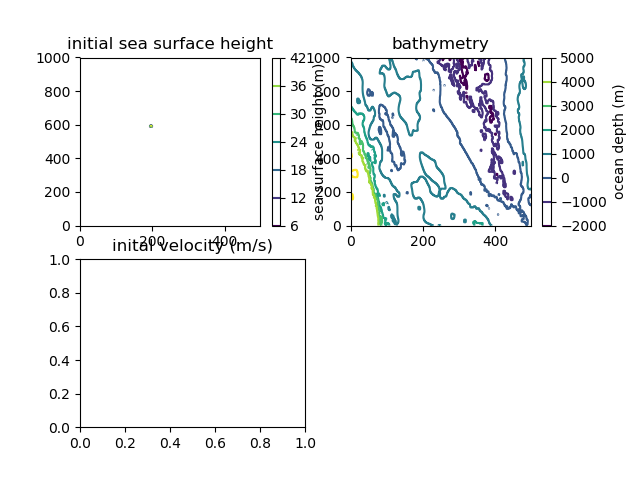

In [223]:
seasurface = np.empty(qp.asnumpy(indonesia.n).shape)
seasurface[::-1] = qp.asnumpy(indonesia.n)
bathymetry = -qp.asnumpy(indonesia.h)


plt.figure(115)
plt.title('initial conditions of indonesia simulation')

plt.subplot(221)
a1 = plt.contour(seasurface)
tt1 = plt.title('initial sea surface height')
cb1 = plt.colorbar()
cb1.set_label('sea surface height (m)')

plt.subplot(222)
a2 = plt.contour(-bathymetry)
tt2 = plt.title('bathymetry')
cb2 = plt.colorbar()
cb2.set_label('ocean depth (m)')

plt.subplot(223)
# a3 = vect()
tt3 = plt.title('inital velocity (m/s)')


In [ ]:
indot, maxindo, minindo, tmindo = simulate(indonesia, 250000)

In [113]:
def plotindopoint(p):
    """finds the index of a latitude, longitude point within the indonesian case class"""
    plat, plon = p[0], p[1]
    lat, lon = indonesia.lat, indonesia.lon
    arglat, arglon = np.argmin(np.abs(lat-plat)), np.argmin(np.abs(lon-plon))
    return arglat, arglon

masq = np.zeros(qp.asnumpy(indonesia.h).shape, dtype=qp.asnumpy(indonesia.h).dtype)
runuplocs = np.array([(5.251, 95.253), (5.452, 95.242), (5.389, 95.960), (2.575, 96.269), (4.208, 96.040)])
radx = masq.shape[0]//100
rady = masq.shape[1]//100
for runuploc in runuplocs:
    arglat, arglon = plotindopoint(runuploc) # gat the index location of this event
    masq[arglat-radx:arglat+radx, arglon-rady:arglon+rady] = 1 # make a small blip around the locatoin

<IPython.core.display.Javascript object>


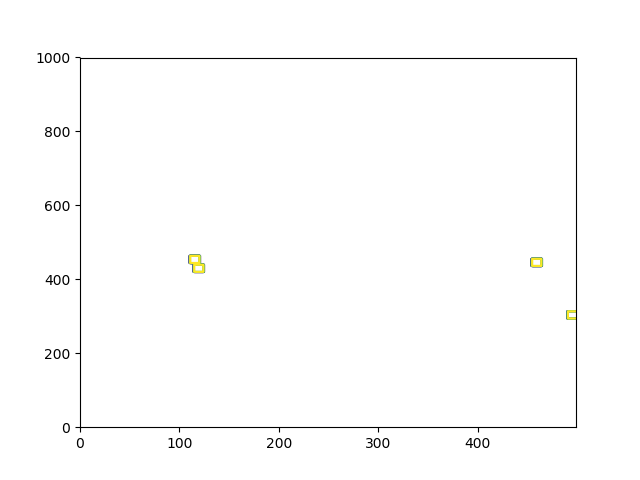

In [114]:
plt.figure(123)
plt.contour(masq)
plt.show()

In [29]:
# shallowWater/data/2004indonesiarunups.txt

In [159]:
indof = np.transpose(indot, (0, 1, 2))
print(indof.shape)
maxt = np.max(indof,axis=(1,2))
print(maxt.shape)
imaxt = np.float32(1.0/maxt)
# plt.figure(888)
# plt.semilogy(maxt)
# plt.show()
# norm_indof = indof*imaxt[:,np.newaxis,np.newaxis]


fig = plt.figure(121)

plt.subplot(1, 3, 1)
f = genframes(norm_indof*0.3, frames=np.linspace(0, indof.shape[0]-1, 120, dtype=int))
anim = animation.ArtistAnimation(fig, f)
cb = plt.colorbar()
h = qp.asnumpy(indonesia.h)
# ht = np.transpose(h)
ht = h
coast = plt.contour(ht-20, colors='black', levels=1)
locmask = plt.contour(masq, colors='green', levels=2)

plt.subplot(1, 3, 2)
plt.title('maximum')
plt.imshow(maxindo+1, cmap='seismic', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

plt.subplot(1, 3, 3)
plt.title('minimum')
plt.imshow(1-minindo, cmap='seismic', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.contour(ht-20, colors='black', levels=1)

plt.show()

(915, 1000, 500)
(915,)


<IPython.core.display.Javascript object>

IndexError: index 92 is out of bounds for axis 0 with size 92

In [207]:
indorut = pd.read_csv('~rrs/shallowWater/data/2004indonesiarunups2.txt',sep='\t')
indoevents = list(indorut.transpose().to_dict().values()) # list of dicts of events' properties
indoevents

[{'Item': '*',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.433,
  'Longitude': 95.236,
  'DistanceFromSource': 245.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 26.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUMATRA ',
  'Latitude': 5.569,
  'Longitude': 95.341,
  'DistanceFromSource': 257.0,
  'IWDay': nan,
  'IWHr': nan,
  'IWMin': nan,
  'TTHr': nan,
  'TTMin': nan,
  'MWDay': nan,
  'MWHr': nan,
  'MMWMin': nan,
  'MaxWaterHeight': 6.1,
  'MaxInundationDistance': nan,
  'Type': 5.0,
  'Per': nan,
  '1st': nan,
  'Mtn': nan,
  'z1': nan,
  'z2': nan},
 {'Item': '* ',
  'Item.1': nan,
  'Country': 'INDONESIA ',
  'State': 'ACEH ',
  'Name': 'ACEH, SUM

In [208]:
# sort the events by proximity to the source
# indoevents.sort(key = lambda event: np.sqrt((indone2004.event['lat'] - event['Latitude'])**2 + (indone2004.event['lat'] - event['Longitude'])**2))
indoevents.sort(key = lambda event: event['DistanceFromSource'])

<IPython.core.display.Javascript object>


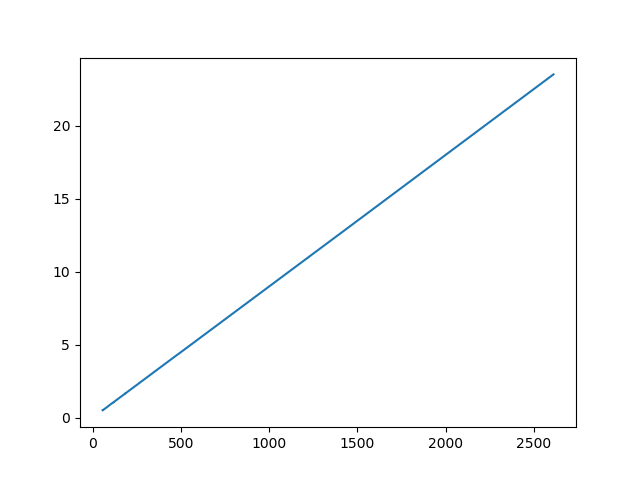

In [213]:
plt.figure(153)
plt.plot([ev['DistanceFromSource'] for ev in indoevents],[np.sqrt((indone2004.event['lat'] - ev['Latitude'])**2 + (indone2004.event['lon'] - ev['Longitude'])**2) for ev in indoevents])
# plt.plot([event['DistanceFromSource'] for event in indoevents])

<IPython.core.display.Javascript object>


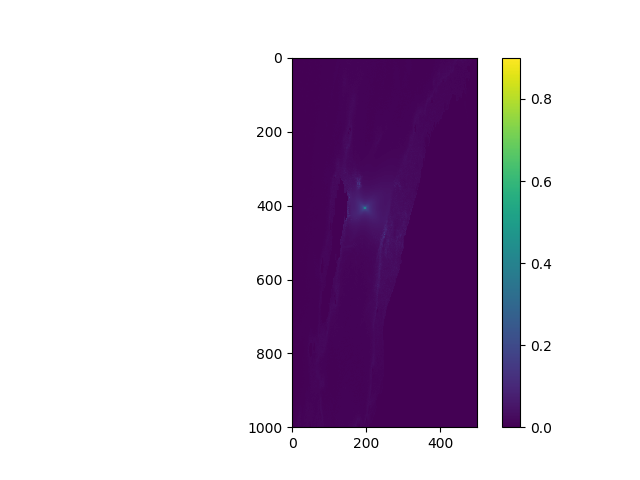

In [162]:
plt.figure(155)
plt.imshow(maxindo)
plt.colorbar()
plt.show()

In [214]:
# simindomaxh = np.array([], dtype=np.float32) # the list of the maximum height that occured at each location
# for event in indoevents: # get the maximum water height at each location in the sim in the order given to us
# #     print(event)
#     evlat = event['Latitude'] # the latitude of the measurement
#     evlon = event['Longitude'] # "  longitude " "       "
#     argevlat = np.argmin(np.abs(indonesia.lat-evlat)) # the array index with latitude closest to point
#     argevlon = np.argmin(np.abs(indonesia.lon-evlon)) # the array index with longitude closest to point
#     mh = maxindo[argevlat, argevlon] # the maximum height at this point
#     if (argevlat == 0 or argevlon == 0): # if the point is out of the map so it just returns the edge
#         mh = 0 # ignore the value at the edge 
#     simindomaxh = np.append(simindomaxh, mh)

# list of indexes maximum height at the location of each event
simindomaxh = [np.max(\
                      maxindo[\
                              np.argmin(np.abs(indonesia.lon-event['Longitude'])), \
                              np.argmin(np.abs(indonesia.lat-event['Latitude']))]) \
               for event in indoevents]
def simindomaxhgenerator():
    for event in indoevents:
        ilon = np.argmin(np.abs(indonesia.lon-event['Longitude']))
        ilat = np.argmin(np.abs(indonesia.lat-event['Latitude']))
        rad = 20
        ilon = np.max((ilon, rad))
        ilat = np.max((ilat, rad))
        
#         print(maxindo.shape, maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad].shape, [ilon-rad,ilon+rad, ilat-rad,ilat+rad])
        mh = np.max(maxindo[ilon-rad:ilon+rad, ilat-rad:ilat+rad])
        yield mh

simindomaxh = np.asarray(list(simindomaxhgenerator()))
simindomaxh

array([0.13154243, 0.13154243, 0.11097669, 0.11097669, 0.13154243,
       0.13154243, 0.13154243, 0.13154243, 0.04207742, 0.04207742,
       0.0289492 , 0.0354387 , 0.03580546, 0.04697248, 0.03580546,
       0.03580546, 0.03580546, 0.03580546, 0.03580546, 0.07430893,
       0.07430893, 0.07430893, 0.07430893, 0.06073043, 0.0259489 ,
       0.02168371, 0.02168371, 0.05789913, 0.05789913, 0.05789913,
       0.05789913, 0.02202451, 0.02202451, 0.02202451, 0.01954961,
       0.02961105, 0.02961105, 0.02961105, 0.02961105, 0.02961105,
       0.02961105, 0.02961105, 0.02961105, 0.03608304, 0.03608304,
       0.03608304, 0.03608304, 0.03608304, 0.02993543, 0.02993543,
       0.03004622, 0.03004622, 0.02274101, 0.02274101, 0.02274101,
       0.0202689 , 0.0202689 , 0.00059911, 0.02003911, 0.02003911,
       0.02003911, 0.02003911, 0.02003911, 0.02003911, 0.02003911,
       0.02003911, 0.0015724 , 0.0015724 , 0.0015724 , 0.0015724 ,
       0.0015724 , 0.0015724 , 0.0015724 , 0.02003911, 0.02003

In [183]:
a = np.arange(64)
a[60:68]

array([60, 61, 62, 63])

<IPython.core.display.Javascript object>


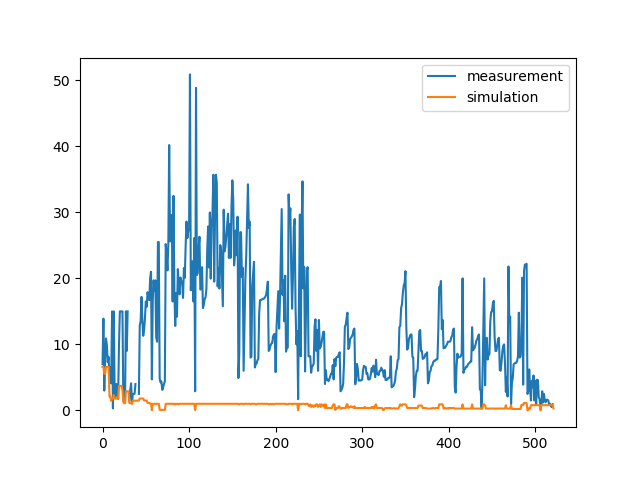

In [218]:
indomaxheights = [event['MaxWaterHeight'] for event in indoevents] # the max water heights of each of the events in the order they are listed
plt.figure(135)
plt.title('maximum heights at various locations')
# plt.subplot(1, 2, 1)
plt.plot(indomaxheights, label='measurement') # real data of max water heights
# plt.subplot(1, 2, 2)
plt.plot(50*simindomaxh, label='simulation') # simulation max water heights in the same order
plt.legend()
plt.show()

In [143]:
# testing
asdf = np.arange(16)
bsdf = 16
asdf = np.append(asdf,bsdf)
asdf

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [145]:
asdf = -asdf
asdf.sort()
asdf

array([-16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
        -3,  -2,  -1,   0])

In [32]:

test = qp.float32(1.32)
type(test)

numpy.float32

In [33]:
asdf = np.round(64*100*np.random.random((8,8)))/100
zxcv = np.arange(64).reshape(8,8)

print(asdf)
print()
print(zxcv)
print()
print(np.max((asdf, zxcv), axis=0))

[[14.23 27.3  56.39 42.94  7.01 58.23 58.99 48.63]
 [32.95  9.61 26.61  3.08 44.49 40.77 32.38 39.43]
 [57.36 57.67 29.06 61.21 43.92 18.52 43.38 51.18]
 [17.89 60.64 13.57 37.91 38.68 31.55 59.31 13.34]
 [28.93 21.59 16.55  4.23 16.79 44.97 20.39 60.83]
 [ 3.8  57.43 52.89 24.36 11.79 55.24 51.71 59.85]
 [57.29 26.25 27.37 62.24 11.43 19.   47.75 26.67]
 [37.16 39.49 53.64 24.68 17.57 53.55 40.73 38.74]]

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]

[[14.23 27.3  56.39 42.94  7.01 58.23 58.99 48.63]
 [32.95  9.61 26.61 11.   44.49 40.77 32.38 39.43]
 [57.36 57.67 29.06 61.21 43.92 21.   43.38 51.18]
 [24.   60.64 26.   37.91 38.68 31.55 59.31 31.  ]
 [32.   33.   34.   35.   36.   44.97 38.   60.83]
 [40.   57.43 52.89 43.   44.   55.24 51.71 59.85]
 [57.29 49.   50.   62.24 52.   53.   54.   55.  ]
 [56.   57.   5

In [34]:
int(np.ceil(100*np.random.rand(1,1)[0]))
# np.linspace?

In [35]:
a = np.ceil(np.random.rand(5, 5)*100)/100-0.5
ag = np.zeros(a.shape, dtype=a.dtype)
al = np.zeros(a.shape, dtype=a.dtype)
gz = np.greater(a,0)
lz = np.less(a, 0)
ag[gz] = a[gz]
al[lz] = a[lz]
ag+al-a

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [36]:
planegauss([2,1])
one = 1
assert one==0, 'wrong'

AssertionError: wrong